## Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Datasets

In [2]:
df = pd.read_csv('D:\\Kumpulan Dataset\\Kaggle\\AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


## Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


In [5]:
df.count()

Date         10468
Open         10468
High         10468
Low          10468
Close        10468
Adj Close    10468
Volume       10468
dtype: int64

In [6]:
df.shape

(10468, 7)

In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10468.000000,10468.000000,10468.000000,10468.000000,10468.000000,1.046800e+04
mean,14.757987,14.921491,14.594484,14.763533,14.130431,3.308489e+08
std,31.914174,32.289158,31.543959,31.929489,31.637275,3.388418e+08
min,0.049665,0.049665,0.049107,0.049107,0.038329,0.000000e+00
25%,0.283482,0.289286,0.276786,0.283482,0.235462,1.237768e+08
50%,0.474107,0.482768,0.465960,0.475446,0.392373,2.181592e+08
75%,14.953303,15.057143,14.692589,14.901964,12.835269,4.105794e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,7.421641e+09


In [9]:
df = df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis='columns')

In [10]:
df.head()

,Date,Open
0,1980-12-12,0.128348
1,1980-12-15,0.122210
2,1980-12-16,0.113281
3,1980-12-17,0.115513
4,1980-12-18,0.118862


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10468 non-null  datetime64[ns]
 1   Open    10468 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 163.7 KB


## Time Series Visualization

Text(0.5, 1.0, 'AAPL Open Value')

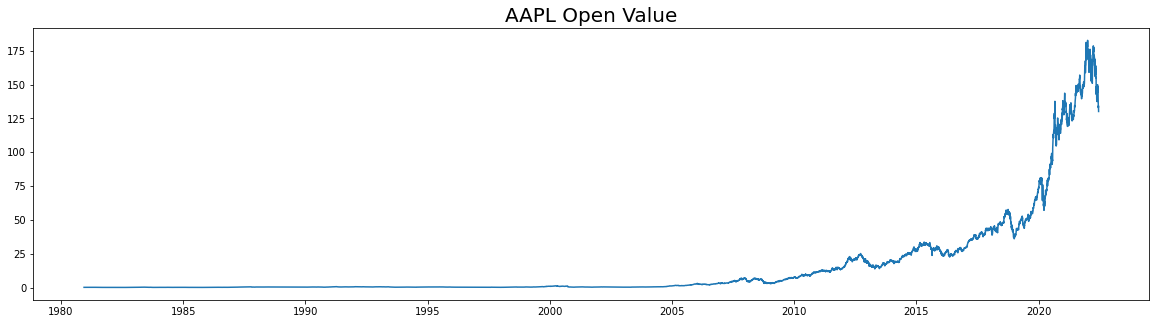

In [12]:
dates = df['Date'].values
temp  = df['Open'].values
 
plt.figure(figsize=(20,5))
plt.plot(dates, temp)
plt.title('AAPL Open Value', fontsize=20)

## Modeling

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)

In [15]:
data_x_train = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

C:\Users\MICROSOFT\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
max_val = df['Open'].max()
print('Max value = ', max_val)

Max value =  182.630005


In [17]:
min_val = df['Open'].min()
print('Min value = ', min_val)

Min value =  0.049665


In [18]:
mae = (max_val-min_val) * (10/100)
print("MAE = ", mae)

MAE =  18.258034000000002


In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 10):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [20]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train, epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
84/84 [==============================] - 14s 132ms/step - loss: 13.3612 - mae: 13.7943 - val_loss: 68.0912 - val_mae: 68.5912
Epoch 2/500
84/84 [==============================] - 11s 120ms/step - loss: 12.1387 - mae: 12.5615 - val_loss: 63.7058 - val_mae: 64.2058
Epoch 3/500
84/84 [==============================] - 6s 69ms/step - loss: 11.0167 - mae: 11.4366 - val_loss: 59.2299 - val_mae: 59.7299
Epoch 4/500
84/84 [==============================] - 6s 72ms/step - loss: 9.9147 - mae: 10.3291 - val_loss: 54.5746 - val_mae: 55.0746
Epoch 5/500
83/84 [============================>.] - ETA: 0s - loss: 8.8247 - mae: 9.2271
MAE of the model < 10% of data scale
84/84 [==============================] - 7s 81ms/step - loss: 8.8414 - mae: 9.2439 - val_loss: 49.9027 - val_mae: 50.4027


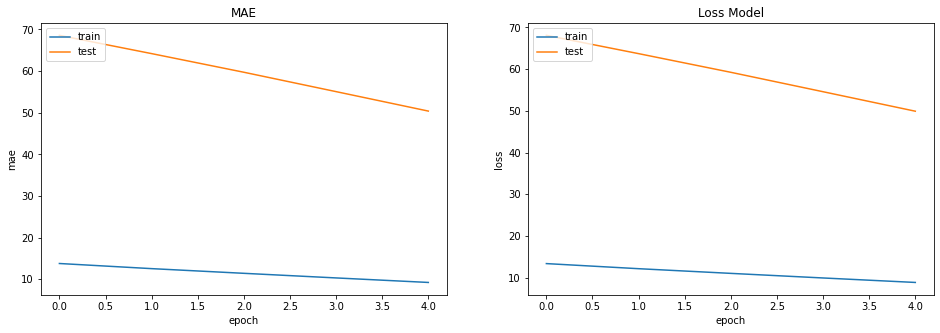

In [21]:
fig = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()